# Assignment 4 - Review part （复现代码）

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

# 神经网络中需要用到的各种节点及操作类
# 神经网络中的节点为 node
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs # 输入
        self.outputs = [] # 输出

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {} # 梯度
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    # 前传
    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    
    # 后传
    def backward(self):

        raise NotImplemented
        
class Input(Node):
    # 接收值
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 初始值
        for n in self.outputs:
            grad_cost = n.gradients[self] # 函数外部节点对自己的导数
            self.gradients[self] = grad_cost * 1 # 外部导数对自己的导数 * 自己对自己的导数
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

# 计算 wx+b
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias # 计算 w*x+b
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.初始化梯度
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T) # 对自己的导数
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost) # 对w的导数=>(x)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False) # 对b的导数=>(1)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    # 激活函数 Sigmoid
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x)) # 对自己的求导
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs} # 初始化

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 均方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    # 图里是每个节点连接情况

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]: # 翻转list
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

# 拓扑排序，先计算的放list前面，后计算的放list后面，入度为0 的放最前面，顺序没要求
# 入度和出度，拿出一个节点，相应做一次操作，入度-1 出度-1
def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    # 计算入度，出度
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    # 排序
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        # 拿出入度为 0 的点
        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        # 拿出一个点后，入度-1，出度-1
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # trainables 所有可训练的点，w,b……
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t] # 梯度下降算法

In [2]:
# 波士顿房价
from sklearn.datasets import load_boston

In [3]:
# 导入数据
data = load_boston()

In [4]:
# loss 函数
losses = []

In [5]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data 导入函数
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data 归一化 （为了消除不同量纲之间的影响）
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1] # 特征数量 
n_hidden = 10 # 维度
# 初始化
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network 建立节点（只接受数值，不接收前面的节点）
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1) # Sigmoid(wx+b) 
l2 = Linear(s1, W2, b2) # (Sigmoid(wx+b))w+b
cost = MSE(y, l2) # 损失函数，平方误差

# 节点初始化
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

# 迭代次数
epochs = 5000  
# Total number of examples 总样本数
m = X_.shape[0]
# SGD 切段，16个样本做一次迭代
batch_size = 16
steps_per_epoch = m // batch_size

# 节点排序
graph = topological_sort(feed_dict)
# 训练节点
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples 采样
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important. 训练，不需要output

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value # 图里最后一个节点，MSE 的输出
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 197.408
Epoch: 101, Loss: 6.826
Epoch: 201, Loss: 5.680
Epoch: 301, Loss: 4.537
Epoch: 401, Loss: 3.928
Epoch: 501, Loss: 3.354
Epoch: 601, Loss: 4.029
Epoch: 701, Loss: 3.907
Epoch: 801, Loss: 3.776
Epoch: 901, Loss: 3.655
Epoch: 1001, Loss: 3.496
Epoch: 1101, Loss: 3.365
Epoch: 1201, Loss: 3.724
Epoch: 1301, Loss: 3.389
Epoch: 1401, Loss: 2.834
Epoch: 1501, Loss: 3.253
Epoch: 1601, Loss: 3.504
Epoch: 1701, Loss: 3.351
Epoch: 1801, Loss: 3.236
Epoch: 1901, Loss: 2.956
Epoch: 2001, Loss: 3.302
Epoch: 2101, Loss: 3.168
Epoch: 2201, Loss: 2.915
Epoch: 2301, Loss: 2.904
Epoch: 2401, Loss: 3.377
Epoch: 2501, Loss: 3.305
Epoch: 2601, Loss: 3.135
Epoch: 2701, Loss: 3.292
Epoch: 2801, Loss: 2.830
Epoch: 2901, Loss: 3.036
Epoch: 3001, Loss: 3.334
Epoch: 3101, Loss: 2.887
Epoch: 3201, Loss: 3.376
Epoch: 3301, Loss: 3.243
Epoch: 3401, Loss: 2.959
Epoch: 3501, Loss: 3.032
Epoch: 3601, Loss: 3.053
Epoch: 3701, Loss: 2.673
Epoch: 3801, Loss: 3.196
Epoc

In [7]:
# 查看预测结果
def forward(outputNode, graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [8]:
# l2 是最终输出的函数，得到一个brath的预测值（16个）
forward(l2,graph)

array([[21.06194526],
       [36.57622004],
       [14.4568119 ],
       [15.47235976],
       [15.76245917],
       [19.40770161],
       [14.2310062 ],
       [21.06967515],
       [19.94873166],
       [19.94873166],
       [16.36019334],
       [37.31874548],
       [22.57705833],
       [17.99033023],
       [30.30379438],
       [48.62531517]])

In [9]:
import matplotlib.pyplot as plt

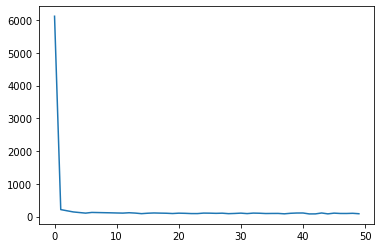

In [10]:
# loss 函数图像（不停下降的过程）
plt.plot(range(len(losses)), losses)

In [11]:
W2.value

array([[ 9.98080351],
       [ 7.50323019],
       [ 6.74753871],
       [ 7.94042445],
       [ 7.13148805],
       [ 6.3650563 ],
       [10.75968925],
       [ 9.87066508],
       [ 5.95773612],
       [-4.68349057]])

In [12]:
X_ = data['data']

In [13]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [16]:
# 一个神经网络的框架，底层基于TensorFlow
import keras

Using TensorFlow backend.


In [17]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [18]:
from keras.layers import Dense # linear层
from keras.models import Sequential
# 先建立好模型
model = Sequential()# 从左往右

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [19]:
# 进行计算
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 204us/step - loss: 161.5579 - mse: 161.5578
Epoch 2/5000
506/506 [==============================] - 0s 65us/step - loss: 82.9159 - mse: 82.9159
Epoch 3/5000
506/506 [==============================] - 0s 71us/step - loss: 81.9953 - mse: 81.9954
Epoch 4/5000
506/506 [==============================] - 0s 59us/step - loss: 84.2171 - mse: 84.2171
Epoch 5/5000
506/506 [==============================] - 0s 79us/step - loss: 85.5547 - mse: 85.5547
Epoch 6/5000
506/506 [==============================] - 0s 63us/step - loss: 85.0291 - mse: 85.0291
Epoch 7/5000
506/506 [==============================] - 0s 71us/step - loss: 85.7116 - mse: 85.7116
Epoch 8/5000
506/506 [==============================] - 0s 65us/step - loss: 85.3796 - mse: 85.3796
Epoch 9/5000
506/506 [==============================] - 0s 69us/step - loss: 85.7798 - mse: 85.7798
Epoch 10/5000
506/506 [==============================] - 0s 71us/step - loss: 85.3802 - mse: 85.3

506/506 [==============================] - 0s 59us/step - loss: 84.7599 - mse: 84.7599
Epoch 163/5000
506/506 [==============================] - 0s 61us/step - loss: 85.7274 - mse: 85.7274
Epoch 164/5000
506/506 [==============================] - 0s 69us/step - loss: 85.5377 - mse: 85.5377
Epoch 165/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9555 - mse: 84.9555
Epoch 166/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0440 - mse: 85.0440
Epoch 167/5000
506/506 [==============================] - 0s 57us/step - loss: 85.7709 - mse: 85.7709
Epoch 168/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7822 - mse: 84.7822
Epoch 169/5000
506/506 [==============================] - 0s 73us/step - loss: 84.9768 - mse: 84.9768
Epoch 170/5000
506/506 [==============================] - 0s 75us/step - loss: 85.6286 - mse: 85.6286
Epoch 171/5000
506/506 [==============================] - 0s 65us/step - loss: 84.8685 - mse: 84.

506/506 [==============================] - 0s 63us/step - loss: 84.3942 - mse: 84.3942
Epoch 323/5000
506/506 [==============================] - 0s 63us/step - loss: 85.4655 - mse: 85.4655
Epoch 324/5000
506/506 [==============================] - 0s 73us/step - loss: 84.9118 - mse: 84.9118
Epoch 325/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9247 - mse: 84.9247
Epoch 326/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7671 - mse: 84.7671
Epoch 327/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0592 - mse: 85.0592
Epoch 328/5000
506/506 [==============================] - 0s 73us/step - loss: 85.4167 - mse: 85.4167
Epoch 329/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9012 - mse: 84.9012
Epoch 330/5000
506/506 [==============================] - 0s 71us/step - loss: 84.7335 - mse: 84.7335
Epoch 331/5000
506/506 [==============================] - 0s 53us/step - loss: 85.5012 - mse: 85.

506/506 [==============================] - 0s 59us/step - loss: 84.7952 - mse: 84.7953
Epoch 483/5000
506/506 [==============================] - 0s 69us/step - loss: 85.0705 - mse: 85.0705
Epoch 484/5000
506/506 [==============================] - 0s 77us/step - loss: 85.1507 - mse: 85.1507
Epoch 485/5000
506/506 [==============================] - 0s 57us/step - loss: 85.1745 - mse: 85.1745
Epoch 486/5000
506/506 [==============================] - 0s 77us/step - loss: 84.9888 - mse: 84.9888
Epoch 487/5000
506/506 [==============================] - 0s 71us/step - loss: 84.8416 - mse: 84.8416
Epoch 488/5000
506/506 [==============================] - 0s 75us/step - loss: 84.5026 - mse: 84.5026
Epoch 489/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7212 - mse: 84.7212
Epoch 490/5000
506/506 [==============================] - 0s 79us/step - loss: 85.3778 - mse: 85.3778
Epoch 491/5000
506/506 [==============================] - 0s 75us/step - loss: 85.0637 - mse: 85.

506/506 [==============================] - 0s 65us/step - loss: 84.9846 - mse: 84.9846
Epoch 643/5000
506/506 [==============================] - 0s 67us/step - loss: 85.2477 - mse: 85.2477
Epoch 644/5000
506/506 [==============================] - 0s 69us/step - loss: 85.2389 - mse: 85.2389
Epoch 645/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8407 - mse: 84.8407
Epoch 646/5000
506/506 [==============================] - 0s 61us/step - loss: 85.0839 - mse: 85.0839
Epoch 647/5000
506/506 [==============================] - 0s 59us/step - loss: 84.9185 - mse: 84.9185
Epoch 648/5000
506/506 [==============================] - 0s 61us/step - loss: 84.7449 - mse: 84.7449
Epoch 649/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8180 - mse: 84.8180
Epoch 650/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0357 - mse: 85.0357
Epoch 651/5000
506/506 [==============================] - 0s 63us/step - loss: 85.1082 - mse: 85.

506/506 [==============================] - 0s 53us/step - loss: 85.2298 - mse: 85.2299
Epoch 802/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1858 - mse: 85.1858
Epoch 803/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6697 - mse: 84.6697
Epoch 804/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8827 - mse: 84.8827
Epoch 805/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0302 - mse: 85.0302
Epoch 806/5000
506/506 [==============================] - 0s 57us/step - loss: 85.1998 - mse: 85.1998
Epoch 807/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7668 - mse: 84.7668
Epoch 808/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7754 - mse: 84.7754
Epoch 809/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8100 - mse: 84.8100
Epoch 810/5000
506/506 [==============================] - 0s 57us/step - loss: 85.6966 - mse: 85.

506/506 [==============================] - 0s 71us/step - loss: 85.1975 - mse: 85.1975
Epoch 962/5000
506/506 [==============================] - 0s 57us/step - loss: 84.4019 - mse: 84.4019
Epoch 963/5000
506/506 [==============================] - 0s 61us/step - loss: 84.1015 - mse: 84.1015
Epoch 964/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7578 - mse: 84.7578
Epoch 965/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1291 - mse: 85.1291
Epoch 966/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8829 - mse: 84.8829
Epoch 967/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9058 - mse: 84.9058
Epoch 968/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0955 - mse: 85.0955
Epoch 969/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7802 - mse: 84.7802
Epoch 970/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8303 - mse: 84.

506/506 [==============================] - 0s 45us/step - loss: 84.6740 - mse: 84.6740
Epoch 1042/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0709 - mse: 85.0709
Epoch 1043/5000
506/506 [==============================] - 0s 63us/step - loss: 85.2114 - mse: 85.2114
Epoch 1044/5000
506/506 [==============================] - 0s 99us/step - loss: 84.8414 - mse: 84.8414
Epoch 1045/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9174 - mse: 84.9174
Epoch 1046/5000
506/506 [==============================] - 0s 59us/step - loss: 85.3884 - mse: 85.3884
Epoch 1047/5000
506/506 [==============================] - 0s 77us/step - loss: 84.4808 - mse: 84.4808
Epoch 1048/5000
506/506 [==============================] - 0s 91us/step - loss: 85.2132 - mse: 85.2132
Epoch 1049/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9218 - mse: 84.9218
Epoch 1050/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3959 -

506/506 [==============================] - 0s 53us/step - loss: 84.7999 - mse: 84.7999
Epoch 1199/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6327 - mse: 84.6327
Epoch 1200/5000
506/506 [==============================] - 0s 79us/step - loss: 84.5477 - mse: 84.5477
Epoch 1201/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8961 - mse: 84.8961
Epoch 1202/5000
506/506 [==============================] - 0s 71us/step - loss: 85.0589 - mse: 85.0589
Epoch 1203/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1077 - mse: 85.1077
Epoch 1204/5000
506/506 [==============================] - 0s 47us/step - loss: 84.8586 - mse: 84.8586
Epoch 1205/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2344 - mse: 85.2344
Epoch 1206/5000
506/506 [==============================] - 0s 117us/step - loss: 85.2776 - mse: 85.2776
Epoch 1207/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1382 

506/506 [==============================] - 0s 55us/step - loss: 84.8055 - mse: 84.8055
Epoch 1357/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8300 - mse: 84.8300
Epoch 1358/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0521 - mse: 85.0521
Epoch 1359/5000
506/506 [==============================] - 0s 105us/step - loss: 85.1779 - mse: 85.1779
Epoch 1360/5000
506/506 [==============================] - 0s 59us/step - loss: 85.0152 - mse: 85.0152
Epoch 1361/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6280 - mse: 84.6280
Epoch 1362/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0203 - mse: 85.0203
Epoch 1363/5000
506/506 [==============================] - 0s 49us/step - loss: 84.4812 - mse: 84.4811
Epoch 1364/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3816 - mse: 85.3816
Epoch 1365/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8120 

506/506 [==============================] - 0s 51us/step - loss: 84.3556 - mse: 84.3556
Epoch 1515/5000
506/506 [==============================] - 0s 51us/step - loss: 85.4342 - mse: 85.4342
Epoch 1516/5000
506/506 [==============================] - 0s 55us/step - loss: 84.4187 - mse: 84.4187
Epoch 1517/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3212 - mse: 85.3212
Epoch 1518/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0713 - mse: 85.0713
Epoch 1519/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8328 - mse: 84.8328
Epoch 1520/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8106 - mse: 84.8106
Epoch 1521/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6392 - mse: 84.6392
Epoch 1522/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9489 - mse: 84.9489
Epoch 1523/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9281 -

506/506 [==============================] - 0s 93us/step - loss: 84.6472 - mse: 84.6471
Epoch 1673/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7277 - mse: 84.7277
Epoch 1674/5000
506/506 [==============================] - 0s 67us/step - loss: 84.8105 - mse: 84.8105
Epoch 1675/5000
506/506 [==============================] - 0s 97us/step - loss: 84.7520 - mse: 84.7520
Epoch 1676/5000
506/506 [==============================] - 0s 55us/step - loss: 85.2508 - mse: 85.2507
Epoch 1677/5000
506/506 [==============================] - 0s 47us/step - loss: 85.3135 - mse: 85.3135
Epoch 1678/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9745 - mse: 84.9745
Epoch 1679/5000
506/506 [==============================] - 0s 99us/step - loss: 84.9135 - mse: 84.9135
Epoch 1680/5000
506/506 [==============================] - 0s 79us/step - loss: 84.4325 - mse: 84.4325
Epoch 1681/5000
506/506 [==============================] - 0s 63us/step - loss: 84.9868 -

506/506 [==============================] - 0s 73us/step - loss: 84.9957 - mse: 84.9957
Epoch 1831/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1670 - mse: 85.1670
Epoch 1832/5000
506/506 [==============================] - 0s 73us/step - loss: 84.4232 - mse: 84.4232
Epoch 1833/5000
506/506 [==============================] - 0s 51us/step - loss: 84.6874 - mse: 84.6874
Epoch 1834/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8537 - mse: 84.8537
Epoch 1835/5000
506/506 [==============================] - 0s 59us/step - loss: 85.0620 - mse: 85.0620
Epoch 1836/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8469 - mse: 84.8469
Epoch 1837/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9193 - mse: 84.9193
Epoch 1838/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0232 - mse: 85.0232
Epoch 1839/5000
506/506 [==============================] - 0s 69us/step - loss: 85.0642 -

506/506 [==============================] - 0s 53us/step - loss: 85.0078 - mse: 85.0078
Epoch 1989/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1844 - mse: 85.1844
Epoch 1990/5000
506/506 [==============================] - 0s 61us/step - loss: 84.9366 - mse: 84.9366
Epoch 1991/5000
506/506 [==============================] - 0s 49us/step - loss: 85.5823 - mse: 85.5823
Epoch 1992/5000
506/506 [==============================] - 0s 140us/step - loss: 84.9952 - mse: 84.9952
Epoch 1993/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9609 - mse: 84.9609
Epoch 1994/5000
506/506 [==============================] - 0s 61us/step - loss: 85.3405 - mse: 85.3405
Epoch 1995/5000
506/506 [==============================] - 0s 57us/step - loss: 84.6352 - mse: 84.6352
Epoch 1996/5000
506/506 [==============================] - 0s 59us/step - loss: 84.5372 - mse: 84.5372
Epoch 1997/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9414 

506/506 [==============================] - 0s 49us/step - loss: 84.5796 - mse: 84.5796
Epoch 2147/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0551 - mse: 85.0552
Epoch 2148/5000
506/506 [==============================] - 0s 67us/step - loss: 84.2491 - mse: 84.2491
Epoch 2149/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3658 - mse: 85.3658
Epoch 2150/5000
506/506 [==============================] - 0s 93us/step - loss: 85.1874 - mse: 85.1874
Epoch 2151/5000
506/506 [==============================] - 0s 55us/step - loss: 84.9341 - mse: 84.9341
Epoch 2152/5000
506/506 [==============================] - 0s 55us/step - loss: 84.6849 - mse: 84.6849
Epoch 2153/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7227 - mse: 84.7227
Epoch 2154/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8634 - mse: 84.8634
Epoch 2155/5000
506/506 [==============================] - 0s 53us/step - loss: 84.6232 -

506/506 [==============================] - 0s 63us/step - loss: 85.8874 - mse: 85.8874
Epoch 2304/5000
506/506 [==============================] - 0s 99us/step - loss: 85.4031 - mse: 85.4031
Epoch 2305/5000
506/506 [==============================] - 0s 73us/step - loss: 85.1463 - mse: 85.1463
Epoch 2306/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9924 - mse: 84.9924
Epoch 2307/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9548 - mse: 84.9548
Epoch 2308/5000
506/506 [==============================] - 0s 99us/step - loss: 85.1424 - mse: 85.1424
Epoch 2309/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5124 - mse: 85.5124
Epoch 2310/5000
506/506 [==============================] - 0s 57us/step - loss: 84.2186 - mse: 84.2186
Epoch 2311/5000
506/506 [==============================] - 0s 65us/step - loss: 85.0771 - mse: 85.0771
Epoch 2312/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7650 -

506/506 [==============================] - 0s 97us/step - loss: 84.6171 - mse: 84.6171
Epoch 2461/5000
506/506 [==============================] - 0s 45us/step - loss: 85.3684 - mse: 85.3684
Epoch 2462/5000
506/506 [==============================] - 0s 57us/step - loss: 84.7537 - mse: 84.7537
Epoch 2463/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8589 - mse: 84.8589
Epoch 2464/5000
506/506 [==============================] - 0s 57us/step - loss: 84.4952 - mse: 84.4952
Epoch 2465/5000
506/506 [==============================] - 0s 79us/step - loss: 85.4125 - mse: 85.4125
Epoch 2466/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7920 - mse: 84.7920
Epoch 2467/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8793 - mse: 84.8793
Epoch 2468/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0387 - mse: 85.0387
Epoch 2469/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0504 -

506/506 [==============================] - 0s 61us/step - loss: 85.3872 - mse: 85.3872
Epoch 2619/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3470 - mse: 85.3470
Epoch 2620/5000
506/506 [==============================] - 0s 69us/step - loss: 84.8040 - mse: 84.8040
Epoch 2621/5000
506/506 [==============================] - 0s 83us/step - loss: 84.4728 - mse: 84.4728
Epoch 2622/5000
506/506 [==============================] - 0s 91us/step - loss: 84.8548 - mse: 84.8548
Epoch 2623/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0121 - mse: 85.0121
Epoch 2624/5000
506/506 [==============================] - 0s 65us/step - loss: 85.0773 - mse: 85.0773
Epoch 2625/5000
506/506 [==============================] - 0s 65us/step - loss: 84.7776 - mse: 84.7776
Epoch 2626/5000
506/506 [==============================] - 0s 77us/step - loss: 84.8931 - mse: 84.8931
Epoch 2627/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9012 -

506/506 [==============================] - 0s 57us/step - loss: 84.8806 - mse: 84.8806
Epoch 2777/5000
506/506 [==============================] - 0s 57us/step - loss: 85.4871 - mse: 85.4871
Epoch 2778/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9357 - mse: 84.9357
Epoch 2779/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9048 - mse: 84.9048
Epoch 2780/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9833 - mse: 84.9833
Epoch 2781/5000
506/506 [==============================] - 0s 99us/step - loss: 84.6465 - mse: 84.6465
Epoch 2782/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6106 - mse: 84.6106
Epoch 2783/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0488 - mse: 85.0489
Epoch 2784/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9799 - mse: 84.9799
Epoch 2785/5000
506/506 [==============================] - 0s 111us/step - loss: 84.4783 

506/506 [==============================] - 0s 53us/step - loss: 84.8332 - mse: 84.8332
Epoch 2935/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0028 - mse: 85.0028
Epoch 2936/5000
506/506 [==============================] - 0s 57us/step - loss: 85.2770 - mse: 85.2770
Epoch 2937/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7247 - mse: 84.7247
Epoch 2938/5000
506/506 [==============================] - 0s 73us/step - loss: 84.8082 - mse: 84.8082
Epoch 2939/5000
506/506 [==============================] - 0s 59us/step - loss: 84.2737 - mse: 84.2737
Epoch 2940/5000
506/506 [==============================] - 0s 53us/step - loss: 84.8239 - mse: 84.8240
Epoch 2941/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0082 - mse: 85.0082
Epoch 2942/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1682 - mse: 85.1682
Epoch 2943/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1985 -

506/506 [==============================] - 0s 53us/step - loss: 85.1294 - mse: 85.1294
Epoch 3092/5000
506/506 [==============================] - 0s 61us/step - loss: 85.0070 - mse: 85.0070
Epoch 3093/5000
506/506 [==============================] - 0s 71us/step - loss: 85.1749 - mse: 85.1749
Epoch 3094/5000
506/506 [==============================] - 0s 53us/step - loss: 84.6980 - mse: 84.6980
Epoch 3095/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9362 - mse: 84.9362
Epoch 3096/5000
506/506 [==============================] - 0s 47us/step - loss: 85.4747 - mse: 85.4747
Epoch 3097/5000
506/506 [==============================] - 0s 101us/step - loss: 84.7689 - mse: 84.7689
Epoch 3098/5000
506/506 [==============================] - 0s 49us/step - loss: 85.2132 - mse: 85.2132
Epoch 3099/5000
506/506 [==============================] - 0s 49us/step - loss: 85.2819 - mse: 85.2819
Epoch 3100/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8775 

506/506 [==============================] - 0s 115us/step - loss: 84.4192 - mse: 84.4192
Epoch 3250/5000
506/506 [==============================] - 0s 43us/step - loss: 84.5070 - mse: 84.5070
Epoch 3251/5000
506/506 [==============================] - 0s 59us/step - loss: 84.5790 - mse: 84.5790
Epoch 3252/5000
506/506 [==============================] - 0s 51us/step - loss: 85.6401 - mse: 85.6401
Epoch 3253/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1142 - mse: 85.1142
Epoch 3254/5000
506/506 [==============================] - 0s 57us/step - loss: 85.2005 - mse: 85.2005
Epoch 3255/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9764 - mse: 84.9764
Epoch 3256/5000
506/506 [==============================] - 0s 75us/step - loss: 84.9154 - mse: 84.9154
Epoch 3257/5000
506/506 [==============================] - 0s 93us/step - loss: 85.6816 - mse: 85.6816
Epoch 3258/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1363 

506/506 [==============================] - 0s 67us/step - loss: 85.0033 - mse: 85.0033
Epoch 3408/5000
506/506 [==============================] - 0s 73us/step - loss: 84.6242 - mse: 84.6242
Epoch 3409/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1330 - mse: 85.1330
Epoch 3410/5000
506/506 [==============================] - 0s 126us/step - loss: 85.1951 - mse: 85.1951
Epoch 3411/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7202 - mse: 84.7202
Epoch 3412/5000
506/506 [==============================] - 0s 61us/step - loss: 84.3531 - mse: 84.3531
Epoch 3413/5000
506/506 [==============================] - 0s 59us/step - loss: 84.4862 - mse: 84.4862
Epoch 3414/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0572 - mse: 85.0572
Epoch 3415/5000
506/506 [==============================] - 0s 75us/step - loss: 84.8472 - mse: 84.8472
Epoch 3416/5000
506/506 [==============================] - 0s 103us/step - loss: 84.7422

506/506 [==============================] - 0s 63us/step - loss: 84.9605 - mse: 84.9605
Epoch 3565/5000
506/506 [==============================] - 0s 61us/step - loss: 85.5901 - mse: 85.5901
Epoch 3566/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8527 - mse: 84.8527
Epoch 3567/5000
506/506 [==============================] - 0s 55us/step - loss: 84.4613 - mse: 84.4613
Epoch 3568/5000
506/506 [==============================] - 0s 91us/step - loss: 84.9757 - mse: 84.9757
Epoch 3569/5000
506/506 [==============================] - 0s 63us/step - loss: 85.2644 - mse: 85.2644
Epoch 3570/5000
506/506 [==============================] - 0s 55us/step - loss: 85.4015 - mse: 85.4015
Epoch 3571/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0632 - mse: 85.0632
Epoch 3572/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9391 - mse: 84.9391
Epoch 3573/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1043 -

506/506 [==============================] - 0s 51us/step - loss: 85.0580 - mse: 85.0580
Epoch 3723/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0048 - mse: 85.0048
Epoch 3724/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8821 - mse: 84.8821
Epoch 3725/5000
506/506 [==============================] - 0s 75us/step - loss: 85.9220 - mse: 85.9220
Epoch 3726/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9631 - mse: 84.9631
Epoch 3727/5000
506/506 [==============================] - 0s 97us/step - loss: 84.9439 - mse: 84.9439
Epoch 3728/5000
506/506 [==============================] - 0s 53us/step - loss: 85.2121 - mse: 85.2121
Epoch 3729/5000
506/506 [==============================] - 0s 53us/step - loss: 84.8560 - mse: 84.8560
Epoch 3730/5000
506/506 [==============================] - 0s 55us/step - loss: 85.2525 - mse: 85.2525
Epoch 3731/5000
506/506 [==============================] - 0s 97us/step - loss: 84.8222 -

506/506 [==============================] - 0s 53us/step - loss: 84.8766 - mse: 84.8766
Epoch 3881/5000
506/506 [==============================] - 0s 59us/step - loss: 84.6307 - mse: 84.6307
Epoch 3882/5000
506/506 [==============================] - 0s 63us/step - loss: 84.6270 - mse: 84.6270
Epoch 3883/5000
506/506 [==============================] - 0s 63us/step - loss: 85.3994 - mse: 85.3994
Epoch 3884/5000
506/506 [==============================] - 0s 71us/step - loss: 84.9119 - mse: 84.9119
Epoch 3885/5000
506/506 [==============================] - 0s 55us/step - loss: 84.9536 - mse: 84.9536
Epoch 3886/5000
506/506 [==============================] - 0s 55us/step - loss: 85.3174 - mse: 85.3174
Epoch 3887/5000
506/506 [==============================] - 0s 115us/step - loss: 84.6289 - mse: 84.6289
Epoch 3888/5000
506/506 [==============================] - 0s 53us/step - loss: 85.2175 - mse: 85.2175
Epoch 3889/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9496 

506/506 [==============================] - 0s 61us/step - loss: 85.3008 - mse: 85.3008
Epoch 4037/5000
506/506 [==============================] - 0s 59us/step - loss: 85.2524 - mse: 85.2524
Epoch 4038/5000
506/506 [==============================] - 0s 61us/step - loss: 85.1427 - mse: 85.1427
Epoch 4039/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8957 - mse: 84.8957
Epoch 4040/5000
506/506 [==============================] - 0s 55us/step - loss: 84.3569 - mse: 84.3569
Epoch 4041/5000
506/506 [==============================] - 0s 57us/step - loss: 85.1478 - mse: 85.1478
Epoch 4042/5000
506/506 [==============================] - 0s 59us/step - loss: 84.2686 - mse: 84.2686
Epoch 4043/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7009 - mse: 84.7009
Epoch 4044/5000
506/506 [==============================] - 0s 49us/step - loss: 84.6366 - mse: 84.6366
Epoch 4045/5000
506/506 [==============================] - 0s 81us/step - loss: 84.4055 -

506/506 [==============================] - 0s 53us/step - loss: 85.4875 - mse: 85.4875
Epoch 4195/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7402 - mse: 84.7402
Epoch 4196/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7406 - mse: 84.7406
Epoch 4197/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1850 - mse: 85.1850
Epoch 4198/5000
506/506 [==============================] - 0s 99us/step - loss: 85.2131 - mse: 85.2131
Epoch 4199/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9801 - mse: 84.9801
Epoch 4200/5000
506/506 [==============================] - 0s 53us/step - loss: 84.8290 - mse: 84.8290
Epoch 4201/5000
506/506 [==============================] - 0s 73us/step - loss: 85.6279 - mse: 85.6280
Epoch 4202/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7404 - mse: 84.7404
Epoch 4203/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9646 -

506/506 [==============================] - 0s 85us/step - loss: 85.3059 - mse: 85.3059
Epoch 4353/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7848 - mse: 84.7848
Epoch 4354/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8775 - mse: 84.8775
Epoch 4355/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9006 - mse: 84.9006
Epoch 4356/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9272 - mse: 84.9272
Epoch 4357/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0435 - mse: 85.0434
Epoch 4358/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1515 - mse: 85.1515
Epoch 4359/5000
506/506 [==============================] - 0s 103us/step - loss: 84.6452 - mse: 84.6452
Epoch 4360/5000
506/506 [==============================] - 0s 57us/step - loss: 84.7359 - mse: 84.7359
Epoch 4361/5000
506/506 [==============================] - 0s 47us/step - loss: 85.3731 

506/506 [==============================] - 0s 57us/step - loss: 85.1446 - mse: 85.1446
Epoch 4510/5000
506/506 [==============================] - 0s 51us/step - loss: 85.5885 - mse: 85.5885
Epoch 4511/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6805 - mse: 84.6805
Epoch 4512/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0498 - mse: 85.0498
Epoch 4513/5000
506/506 [==============================] - 0s 71us/step - loss: 85.2063 - mse: 85.2063
Epoch 4514/5000
506/506 [==============================] - 0s 65us/step - loss: 84.5083 - mse: 84.5083
Epoch 4515/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0556 - mse: 85.0556
Epoch 4516/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7752 - mse: 84.7752
Epoch 4517/5000
506/506 [==============================] - 0s 97us/step - loss: 84.9770 - mse: 84.9770
Epoch 4518/5000
506/506 [==============================] - 0s 49us/step - loss: 85.2640 -

506/506 [==============================] - 0s 57us/step - loss: 84.7683 - mse: 84.7683
Epoch 4668/5000
506/506 [==============================] - 0s 63us/step - loss: 85.1457 - mse: 85.1457
Epoch 4669/5000
506/506 [==============================] - 0s 67us/step - loss: 84.6948 - mse: 84.6948
Epoch 4670/5000
506/506 [==============================] - 0s 65us/step - loss: 84.8961 - mse: 84.8961
Epoch 4671/5000
506/506 [==============================] - 0s 126us/step - loss: 85.0891 - mse: 85.0891
Epoch 4672/5000
506/506 [==============================] - 0s 59us/step - loss: 85.0860 - mse: 85.0860
Epoch 4673/5000
506/506 [==============================] - 0s 55us/step - loss: 84.8973 - mse: 84.8973
Epoch 4674/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7525 - mse: 84.7526
Epoch 4675/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0651 - mse: 85.0651
Epoch 4676/5000
506/506 [==============================] - 0s 75us/step - loss: 84.9853 

506/506 [==============================] - 0s 91us/step - loss: 85.2738 - mse: 85.2738
Epoch 4826/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9035 - mse: 84.9035
Epoch 4827/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0655 - mse: 85.0655
Epoch 4828/5000
506/506 [==============================] - 0s 43us/step - loss: 84.6638 - mse: 84.6638
Epoch 4829/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9075 - mse: 84.9075
Epoch 4830/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1878 - mse: 85.1878
Epoch 4831/5000
506/506 [==============================] - 0s 97us/step - loss: 84.6654 - mse: 84.6654
Epoch 4832/5000
506/506 [==============================] - 0s 63us/step - loss: 85.0049 - mse: 85.0048
Epoch 4833/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0653 - mse: 85.0653
Epoch 4834/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9168 -

506/506 [==============================] - 0s 53us/step - loss: 84.9360 - mse: 84.9360
Epoch 4984/5000
506/506 [==============================] - 0s 63us/step - loss: 85.1586 - mse: 85.1586
Epoch 4985/5000
506/506 [==============================] - 0s 93us/step - loss: 84.7409 - mse: 84.7409
Epoch 4986/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1319 - mse: 85.1319
Epoch 4987/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7185 - mse: 84.7185
Epoch 4988/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9343 - mse: 84.9343
Epoch 4989/5000
506/506 [==============================] - 0s 61us/step - loss: 84.7189 - mse: 84.7189
Epoch 4990/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9343 - mse: 84.9343
Epoch 4991/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6303 - mse: 84.6303
Epoch 4992/5000
506/506 [==============================] - 0s 51us/step - loss: 84.5680 -